In [90]:
import numpy as np
import xarray as xr
import metpy 
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
#read in data and open it
file = '/home/jstancz/Desktop/groups/ORC-CLIMATE/aoes_repo/obs/MSWEP_daily/MSWEP_201*.nc'

file2 = '/home/jstancz/Desktop/groups/ORC-CLIMATE/aoes_repo/obs/ERA5/daily/2.5deg/lev/u/201*/ERA5_daily_u*.nc'
ds = xr.open_mfdataset(file2,combine='nested',concat_dim='time')

# Slice the dataset for the specified time range and spatial bounds
ds = ds.sel(level = 850,time=slice('2011-01-01', '2018-03-15'))
ds

<xarray.Dataset> Size: 111MB
Dimensions:    (time: 2631, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-01-01 2011-01-02 ... 2018-03-15
    level      float64 8B 850.0
  * latitude   (latitude) float32 292B -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    u          (time, latitude, longitude) float32 111MB dask.array<chunksize=(1, 73, 144), meta=np.ndarray>

In [4]:
def anomalies(ds):
    var = ds.groupby("time.dayofyear")
    climo = ds.groupby("time.dayofyear").mean()
    anom = var - climo
    return anom

In [114]:
#calculate the precipitation anomaly
u_anom = anomalies(ds)
u_anom

<xarray.Dataset> Size: 111MB
Dimensions:    (time: 2631, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-01-01 2011-01-02 ... 2018-03-15
    level      (time) float64 21kB 850.0 850.0 850.0 850.0 ... 850.0 850.0 850.0
  * latitude   (latitude) float32 292B -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
    dayofyear  (time) int64 21kB 1 2 3 4 5 6 7 8 9 ... 67 68 69 70 71 72 73 74
Data variables:
    u          (time, latitude, longitude) float32 111MB dask.array<chunksize=(1, 73, 144), meta=np.ndarray>

In [95]:
import numpy
import scipy.fftpack as fftpack
import scipy.signal as signal

class KFfilter:
    """class for wavenumber-frequency filtering for WK99 and WKH00"""
    def __init__(self, datain, spd, tim_taper=0.1):
        """Arguments:
        
       'datain'    -- the data to be filtered. dimension must be (time, lat, lon)

       'spd'       -- samples per day

       'tim_taper' -- tapering ratio by cos. applay tapering first and last tim_taper%
                      samples. default is cos20 tapering

                      """
        ntim, nlat, nlon = datain.shape

        #remove dominal trend
        data = signal.detrend(datain, axis=0)

        #tapering
        if tim_taper == 'hann':
            window = signal.hann(ntim)
            data = data * window[:,np.newaxis,np.newaxis]
        elif tim_taper > 0:
        
        #taper by cos tapering same dtype as input array
            tp = int(ntim*tim_taper)
            window = numpy.ones(ntim, dtype=datain.dtype)
            x = numpy.arange(tp)
            window[:tp] = 0.5*(1.0-numpy.cos(x*numpy.pi/tp))
            window[-tp:] = 0.5*(1.0-numpy.cos(x[::-1]*numpy.pi/tp))
            data = data * window[:,np.newaxis,np.newaxis]

        #FFT
        self.fftdata = fftpack.fft2(data, axes=(0,2))

        #Note
        # fft is defined by exp(-ikx), so to adjust exp(ikx) multipried minus
        
        wavenumber = -fftpack.fftfreq(nlon)*nlon
        frequency = fftpack.fftfreq(ntim, d=1./float(spd))
        knum, freq = numpy.meshgrid(wavenumber, frequency)

        #make f<0 domain same as f>0 domain
        
        knum[freq<0] = -knum[freq<0]
        freq = numpy.abs(freq)
        self.knum = knum
        self.freq = freq

        self.wavenumber = wavenumber
        self.frequency = frequency
    

    def kfmask(self, fmin=None, fmax=None, kmin=None, kmax=None):
        """return wavenumber-frequency mask for wavefilter method

        Arguments:

           'fmin/fmax' --

           'kmin/kmax' --
        """
        nf, nlat, nk = self.fftdata.shape
        knum = self.knum
        freq = self.freq

        #wavenumber cut-off
        mask = numpy.zeros((nf,nk), dtype=numpy.bool)
        if kmin != None:
            mask = mask | (knum < kmin) 
        if kmax != None:
            mask = mask | (kmax < knum)

        #frequency cutoff
        if fmin != None:
            mask = mask | (freq < fmin)
        if fmax != None:
            mask = mask | (fmax < freq)

        return mask

    def wavefilter(self, mask):
        """apply wavenumber-frequency filtering by original mask.
        
        Arguments:
        
           'mask' -- 2D boolean array (wavenumber, frequency).domain to be filterd
                     is False (True member to be zero)
        """
        wavenumber = self.wavenumber
        frequency = self.frequency
        fftdata = self.fftdata.copy()
        nf, nlat, nk = fftdata.shape

        if (nf, nk) != mask.shape:
            print("mask array size is incorrect.")
            sys.exit()

        mask = numpy.repeat(mask[:,np.newaxis,:], nlat, axis=1)    
        fftdata[mask] = 0.0

        #inverse FFT
        filterd = fftpack.ifft2(fftdata, axes=(0,2))
        return filterd.real


In [96]:
import scipy.fftpack as fftpack
import scipy.signal as signal

# Access the 'precip' variable from the Dataset
u_anom_values = u_anom['u']  # This gets the DataArray


# Apply the KFfilter to the cleaned data
kf_filter = KFfilter(u_anom_values, spd=1, tim_taper=0.1)



#Work with filtering data now

# Create a mask for wavenumber 1-3 and frequency 18-80 days (convert tocycles per day)
wavenumber_min = 1
wavenumber_max = 3
frequency_min = 1./80  
frequency_max = 1./18 

# Apply the filter to select the desired wavenumber-frequency range
mask = kf_filter.kfmask(fmin=frequency_min, fmax=frequency_max, kmin=wavenumber_min, kmax=wavenumber_max)

# Filter the data using the mask
filtered_data = kf_filter.wavefilter(mask)

In [97]:
filtered_data

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.0596789 , -0.05470167, -0.0492151 , ..., -0.07156094,
         -0.06810204, -0.06414447],
        [-0.09391958, -0.09026337, -0.08505461, ..., -0.09468632,
         -0.09619515, -0.09592251],
        ...,
        [-0.16076565, -0.14723307, -0.13207105, ..., -0.18989998,
         -0.1822537 , -0.17249335],
        [-0.05776568, -0.03858614, -0.01878497, ..., -0.11056095,
         -0.09384955, -0.0762199 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.09283073, -0.08898161, -0.08457518, ..., -0.10113768,
         -0.09889325, -0.09613026],
        [-0.09943736, -0.09865547, -0.09623079, ..., -0.09140528,
         -0.09583855, -0.09851159],
        ...,
        [-0.1701364 , -0.16070653, -0.14962678, ..., -

In [98]:
# Assuming filtered_data is a NumPy array of shape (time, lat, lon)
latitudes = u_anom['latitude'].values  # Ensure you have the correct latitude data
longitudes = u_anom['longitude'].values  # Ensure you have the correct longitude data

ds_filtered = xr.Dataset(
    {'u_mjo': (['time', 'latitude', 'longitude'], filtered_data)},
    coords={'time': u_anom['time'], 'latitude': latitudes, 'longitude': longitudes}
)

In [99]:
ds_filtered

<xarray.Dataset> Size: 111MB
Dimensions:    (time: 2631, latitude: 73, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-01-01 2011-01-02 ... 2018-03-15
    level      (time) float64 21kB 850.0 850.0 850.0 850.0 ... 850.0 850.0 850.0
    dayofyear  (time) int64 21kB 1 2 3 4 5 6 7 8 9 ... 67 68 69 70 71 72 73 74
  * latitude   (latitude) float32 292B -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
Data variables:
    u_mjo      (time, latitude, longitude) float32 111MB 0.0 0.0 0.0 ... 0.0 0.0

In [100]:
u_index_filtered = ds_filtered.sel(latitude=slice(-5, 5), longitude=slice(160, 170))
u_index_filtered = u_index_filtered.mean(dim=['latitude', 'longitude'])
u_index_filtered

<xarray.Dataset> Size: 74kB
Dimensions:    (time: 2631)
Coordinates:
  * time       (time) datetime64[ns] 21kB 2011-01-01 2011-01-02 ... 2018-03-15
    level      (time) float64 21kB 850.0 850.0 850.0 850.0 ... 850.0 850.0 850.0
    dayofyear  (time) int64 21kB 1 2 3 4 5 6 7 8 9 ... 67 68 69 70 71 72 73 74
Data variables:
    u_mjo      (time) float32 11kB 0.06974 0.08008 0.08486 ... 0.03774 0.05508

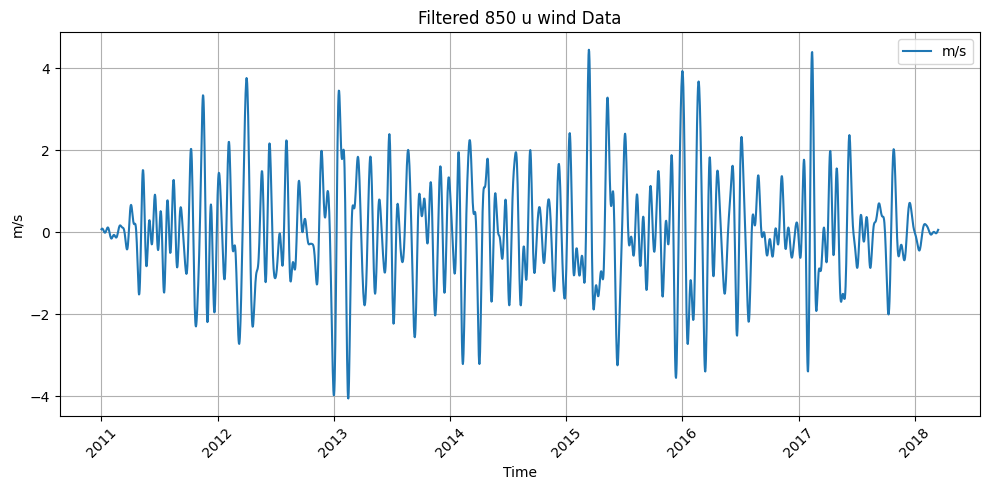

In [101]:
# Select the 'mjo' variable

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(u_index_filtered['time'], u_index_filtered['u_mjo'], label='m/s')
plt.title('Filtered 850 u wind Data')
plt.xlabel('Time')
plt.ylabel('m/s')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [102]:
#write out file to then apply lag regression
u_index_filtered.to_netcdf('/home/jstancz/data/kf_python_u_850.nc')

In [118]:
u_anom= u_anom.sel(latitude=slice(-10, 10))
u_anom
u_anom = u_anom.mean(dim=['latitude','longitude'])
#u_anom

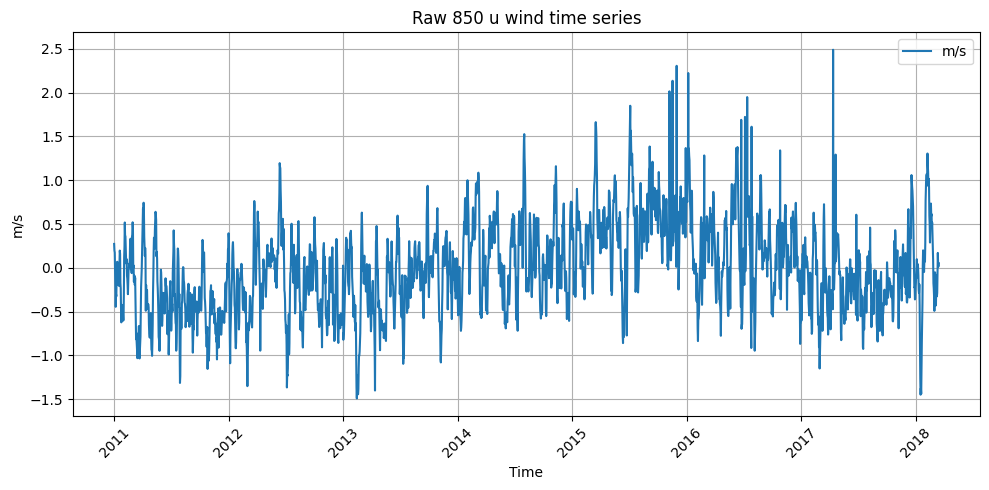

In [119]:
# Select the 'mjo' variable

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(u_anom['time'], u_anom['u'], label='m/s')
plt.title('Raw 850 u-wind time series')
plt.xlabel('Time')
plt.ylabel('m/s')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()